In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaModel, RobertaTokenizer, AdamW
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import random

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# Load dataset
dataset_path = "/kaggle/input/twitter-us-airline/Twitter_US_Airline/Tweets.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.shape

(14640, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df.tail()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [9]:
df.isna() #returns True if value is missing and False if value is not missing

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,False,False,False,True,True,False,True,False,True,False,False,True,False,True,False
1,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False
2,False,False,False,True,True,False,True,False,True,False,False,True,False,False,False
3,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
4,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True
14636,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True
14637,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True
14638,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False


In [10]:
df.isna().any() #same as isna() but it works in column level

tweet_id                        False
airline_sentiment               False
airline_sentiment_confidence    False
negativereason                   True
negativereason_confidence        True
airline                         False
airline_sentiment_gold           True
name                            False
negativereason_gold              True
retweet_count                   False
text                            False
tweet_coord                      True
tweet_created                   False
tweet_location                   True
user_timezone                    True
dtype: bool

In [11]:
df.isna().sum() #count the number of missing values (NaNs) in each column

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [12]:
# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [13]:
# Step 1: Load and Preprocess Data
def clean_text(text):
    import re
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)    # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    return text.strip().lower()

In [14]:
# Apply text cleaning
df["clean_text"] = df["text"].apply(clean_text)

In [15]:
df.shape

(14640, 16)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [17]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercials to the experience...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didnt today must mean i need to take another...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),its really aggressive to blast obnoxious enter...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and its a really big bad thing about it


In [18]:
df.tail()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN,thank you we got on a different flight to chicago
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,leaving over minutes late flight no warnings ...
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN,please bring american airlines to blackberry
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),you have my money you change my flight and don...
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN,we have ppl so we need know how many seats a...


In [19]:
# Extract cleaned texts and labels
texts = df["clean_text"].tolist()
labels = df["airline_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2}).tolist()

In [20]:
# Step 2: Oversample Data for Class Balancing
def oversample_data(texts, labels):
    data = list(zip(texts, labels))
    negative = [x for x in data if x[1] == 0]
    neutral = [x for x in data if x[1] == 1]
    positive = [x for x in data if x[1] == 2]

    neutral_upsampled = resample(neutral, replace=True, n_samples=len(negative), random_state=42)
    positive_upsampled = resample(positive, replace=True, n_samples=len(negative), random_state=42)

    balanced_data = negative + neutral_upsampled + positive_upsampled
    random.shuffle(balanced_data)
    return zip(*balanced_data)

In [21]:
# Step 3: Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [22]:
# Step 4: Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, rnn_output):
        weights = torch.softmax(self.attention(rnn_output), dim=1)
        weighted_output = torch.sum(weights * rnn_output, dim=1)
        return weighted_output, weights

In [23]:
# Step 5: Base Model with RoBERTa + RNN + Attention
class RoBERTaRNNWithAttention(nn.Module):
    def __init__(self, model_type="lstm", hidden_size=128, num_classes=3):
        super(RoBERTaRNNWithAttention, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-large")  # Use roberta-large
        self.rnn_type = model_type.lower()
        self.hidden_size = hidden_size

        if self.rnn_type == "lstm":
            self.rnn = nn.LSTM(self.roberta.config.hidden_size, hidden_size, batch_first=True, bidirectional=True)
        elif self.rnn_type == "bilstm":
            self.rnn = nn.LSTM(self.roberta.config.hidden_size, hidden_size, batch_first=True, bidirectional=True)
        elif self.rnn_type == "gru":
            self.rnn = nn.GRU(self.roberta.config.hidden_size, hidden_size, batch_first=True, bidirectional=True)
        else:
            raise ValueError(f"Unsupported RNN type: {model_type}")

        self.attention = AttentionLayer(hidden_size * 2)  # Bidirectional doubles the size
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze RoBERTa during training
            roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = roberta_output.last_hidden_state
        rnn_output, _ = self.rnn(last_hidden_state)
        attn_output, _ = self.attention(rnn_output)
        logits = self.fc(attn_output)
        return logits

In [24]:
# Step 6: Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.fc = nn.Linear(len(models) * 3, 3)  # For 3 classes (Negative, Neutral, Positive)

    def forward(self, input_ids, attention_mask):
        logits_list = [model(input_ids, attention_mask) for model in self.models]
        logits = torch.cat(logits_list, dim=1)  # Concatenate logits
        return self.fc(logits)

In [25]:
# Step 7: Oversample and Create Dataset
balanced_texts, balanced_labels = oversample_data(texts, labels)

In [26]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")  # Use roberta-large tokenizer
dataset = SentimentDataset(balanced_texts, balanced_labels, tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [27]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [28]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [29]:
# Initialize models
lstm_model = RoBERTaRNNWithAttention(model_type="lstm").to(device)
bilstm_model = RoBERTaRNNWithAttention(model_type="bilstm").to(device)
gru_model = RoBERTaRNNWithAttention(model_type="gru").to(device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
ensemble_model = EnsembleModel([lstm_model, bilstm_model, gru_model]).to(device)

In [31]:
# Optimizer and loss
optimizer = torch.optim.AdamW(ensemble_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [32]:
# Early Stopping Setup
best_val_loss = float("inf")
patience = 5 # Allow more epochs before early stopping(Higher patience for more training epochs)
patience_counter = 0

In [33]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [34]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    ensemble_model.train()
    train_loss, train_correct = 0, 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = ensemble_model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ensemble_model.eval()
    val_loss, val_correct = 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = ensemble_model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()
            val_preds.extend(logits.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(ensemble_model.state_dict(), "best_ensemble_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/20
Train Loss: 0.8470, Train Accuracy: 0.6547
Val Loss: 0.6902, Val Accuracy: 0.7171
Epoch 2/20
Train Loss: 0.5737, Train Accuracy: 0.7715
Val Loss: 0.6444, Val Accuracy: 0.7325
Epoch 3/20
Train Loss: 0.5375, Train Accuracy: 0.7824
Val Loss: 0.6244, Val Accuracy: 0.7470
Epoch 4/20
Train Loss: 0.5212, Train Accuracy: 0.7931
Val Loss: 0.6201, Val Accuracy: 0.7452
Epoch 5/20
Train Loss: 0.5119, Train Accuracy: 0.7956
Val Loss: 0.5885, Val Accuracy: 0.7628
Epoch 6/20
Train Loss: 0.4983, Train Accuracy: 0.8015
Val Loss: 0.5851, Val Accuracy: 0.7681
Epoch 7/20
Train Loss: 0.4916, Train Accuracy: 0.8044
Val Loss: 0.5964, Val Accuracy: 0.7589
Epoch 8/20
Train Loss: 0.4854, Train Accuracy: 0.8064
Val Loss: 0.5812, Val Accuracy: 0.7632


KeyboardInterrupt: 

In [35]:
#Printing
print("train_losses = ", train_losses)
print("train_accuracies = ", train_accuracies)

print("val_losses = ", val_losses)
print("val_accuracies = ", val_accuracies)

print("val_preds = ", val_preds)
print("val_labels = ", val_labels)


train_losses =  [0.8469686991249035, 0.573700195693762, 0.5375051982240913, 0.5212403803836546, 0.5118851658435688, 0.4983042397670929, 0.4915665704202375, 0.4853739768493929]
train_accuracies =  [0.654651110001362, 0.7715076951014663, 0.7824488128206293, 0.7930721387388205, 0.7955690743178826, 0.8015163208789213, 0.8044218459163753, 0.806419394379625]
val_losses =  [0.6902207692464193, 0.6444431644418965, 0.6243714034557343, 0.6201262400634047, 0.5884544350098873, 0.5851314945497375, 0.5963714384514353, 0.5812267604945363]
val_accuracies =  [0.7170873433811512, 0.7325222444161976, 0.7470492100962411, 0.7452333393862357, 0.7628472852732885, 0.7681133103323043, 0.7588523697112766, 0.7632104594152896]
val_preds =  [2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0

In [36]:
# Classification report
print(classification_report(val_labels, val_preds, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.91      0.61      0.73      1845
     Neutral       0.65      0.83      0.73      1839
    Positive       0.80      0.85      0.82      1823

    accuracy                           0.76      5507
   macro avg       0.79      0.76      0.76      5507
weighted avg       0.79      0.76      0.76      5507



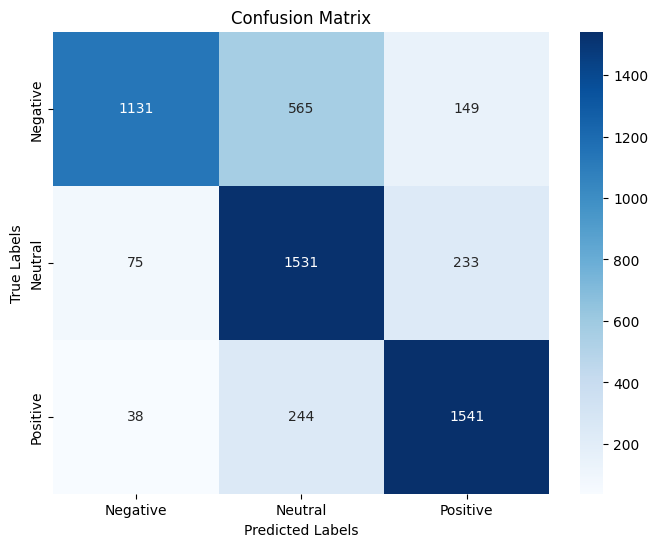

In [37]:
# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

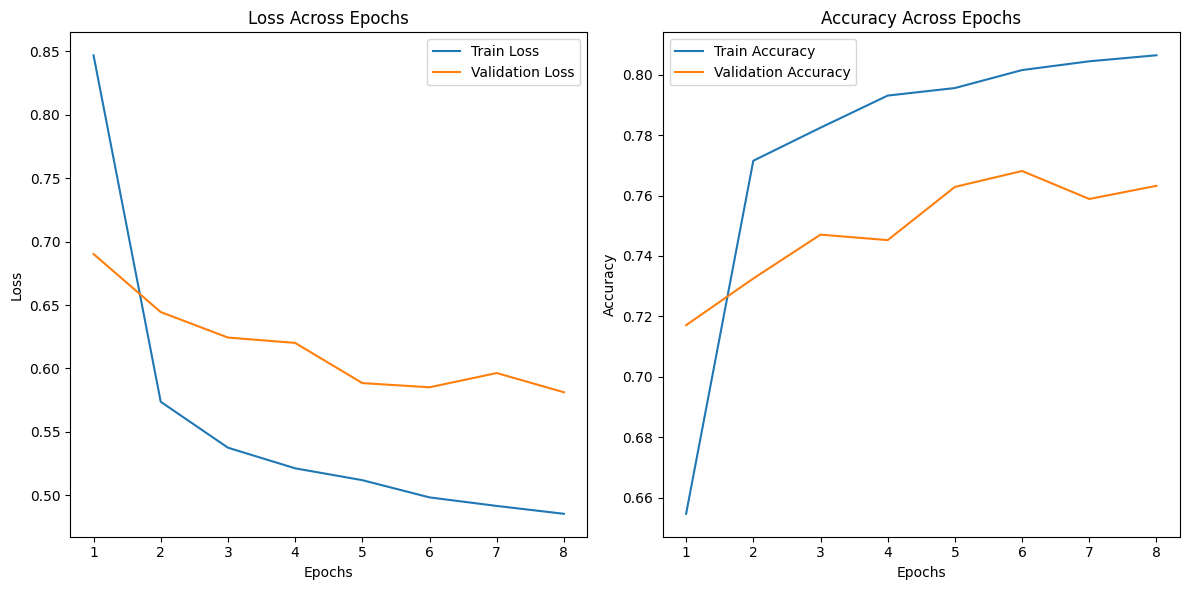

In [38]:
# Plotting Graphs
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Across Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Epochs")
plt.legend()

plt.tight_layout()
plt.show()

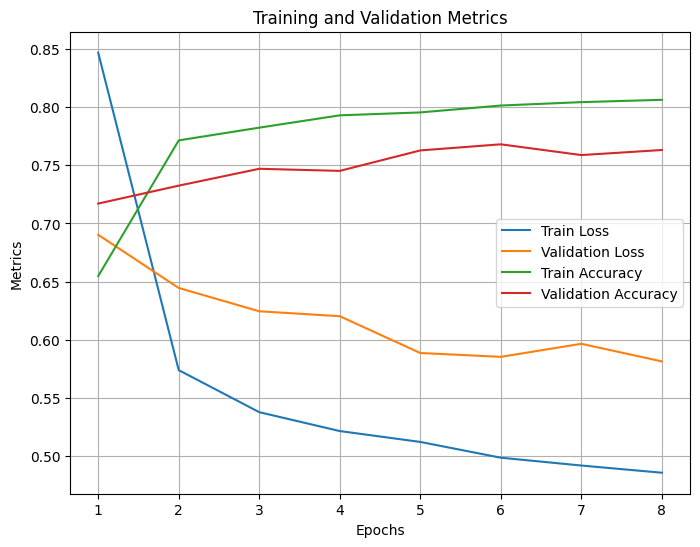

In [39]:
# Final Graph
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid()
plt.show()